In [36]:
! pip install ONE-api
! pip install ibllib

# from google.colab import drive
# drive.mount('/content/gdrive')
import os

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from brainbox.io.one import SpikeSortingLoader
from brainbox.plot import peri_event_time_histogram
from brainbox.singlecell import calculate_peths

from ibllib.atlas import AllenAtlas
from one.api import ONE

one = ONE(base_url='https://openalyx.internationalbrainlab.org', password='international', silent=True)
ba = AllenAtlas()

Helper functions

In [38]:
def remove_nans(lis, indices):
    tes = np.array([[i,val] for i,val in enumerate(lis)])
    row_remove = np.argwhere(np.isnan(tes))
    tes = tes[~np.isnan(tes).any(axis=1)]

    return tes, row_remove[:,0]


def get_spikedata(eid):
    PIDlist = one.eid2pid(eid)
    datalist = []
    print(PIDlist)
    for PID in PIDlist[0]:
        sl = SpikeSortingLoader(pid=PID, one=one, atlas=ba)
        spikes, clusters, channels = sl.load_spike_sorting()
        clusters = sl.merge_clusters(spikes, clusters, channels)
        datalist.append([spikes, clusters, channels])
    return datalist

def select_trials(trial_data, trial_condition, condition):
    indices = [i for i, trial in enumerate(trial_data) if trial_condition[i] == condition and not math.isnan(trial)]
    result = [trial for i, trial in enumerate(trial_data) if i in indices]
    return result, indices


def get_matrices(trials, spikes, relev_neur, param = 'choice', param_condition = -1):


    move_trials, trial_indices = select_trials(trials['firstMovement_times'], trials[param], param_condition)
    print(len(move_trials), move_trials)
    print(len(trial_indices), trial_indices)

    #0D behavioral parameters 
    movement_choices = trials.choice[trial_indices]
    trial_results = trials.feedbackType[trial_indices]
    print(len(movement_choices))

    peth, spike_counts = calculate_peths(
        spikes.times, spikes.clusters, relev_neur,
        move_trials,
        pre_time=3, post_time=3, bin_size=0.05, smoothing=0)

    print('peth["tscale"] contains the timebin centers relative to the event')
    print(f'\npeth["means"] is shaped: {peth["means"].shape}')
    print('This variable is NxB (neurons x timebins) and contains the mean spike rates over trials')
    print(f'\nspike_counts is shaped: {spike_counts.shape}')
    print('This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial')

    # If you just want all the spikes over the entire 0-300 ms window you can sum like this:
    whole_window = np.sum(spike_counts, axis=2)

    print(np.linalg.norm(whole_window))
    print(f'\nwhole_window is shaped: {whole_window.shape}')
    print('This variable is TxN (trials x neurons) and contains summed spike rates per trial')

    trial_data = {}
    trial_data['movement_init_times'] = move_trials
    trial_data['choices'] = movement_choices
    trial_data['feedback'] = trial_results
    trial_data['trial_indices'] = trial_indices

    return peth, spike_counts, trial_data

# get_matrices(trials, spikes, relev_neur)

def gen_eidlist(roi_name):
    ses = one.alyx.rest('sessions', 'list', atlas_acronym=roi_name)
    eids = [i['id'] for i in ses]
    return eids

def check_num_ses(list_of_eids):
    roi_intersection = set(list_of_eids[0]).intersection(*list_of_eids[1:])
    print('Found ' + str(len(list(roi_intersection))) +  'recording sessions')
    return len(list(roi_intersection))

2) **For finding the number (and regions) of simultaneous recordings for each EID. Not necessary to run if already determined which EID(s) to use**

In [59]:
from collections import defaultdict

In [39]:
#loads in csv of brain regions from projection matrix
regions = pd.read_csv('proj_brainregions.csv').columns
roi_comp = []

for i,region in enumerate(regions):
    if region == 'fiber tracts':
        continue
    roi_comp.append(region.split('.')[0])

In [40]:
# sets up eid_dic which contains roi -> list of eid
eid_dic = {}
all_eids = set()
for roi in roi_comp:
    print(roi + ' EID list')
    eids = gen_eidlist(roi)
    print(len(eids), eids)
    eid_dic[roi] = eids
    all_eids.update(eids)

all_eids = list(all_eids)
roi_records = []

for i,eid in enumerate(all_eids):
    roilist = [roi for roi in eid_dic.keys() if eid in eid_dic[roi]]
    roi_records.append(roilist)


FRP EID list
10 ['752456f3-9f47-4fbf-bd44-9d131c0f41aa', '6b0b5d24-bcda-4053-a59c-beaa1fe03b8f', 'dfbe628d-365b-461c-a07f-8b9911ba83aa', '360eac0c-7d2d-4cc1-9dcf-79fc7afc56e7', '4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a', '4d8c7767-981c-4347-8e5e-5d5fffe38534', '65f5c9b4-4440-48b9-b914-c593a5184a18', '8207abc6-6b23-4762-92b4-82e05bed5143', '1191f865-b10a-45c8-9c48-24a980fd9402', '2e6e179c-fccc-4e8f-9448-ce5b6858a183']
MOp EID list
33 ['1d4a7bd6-296a-48b9-b20e-bd0ac80750a5', '6f36868f-5cc1-450c-82fa-6b9829ce0cfe', '5455a21c-1be7-4cae-ae8e-8853a8d5f55e', '8d316998-28c3-4265-b029-e2ca82375b2f', '1b20f589-6177-4e5c-9090-9a609a16944b', '7082d8ff-255a-47d7-a839-bf093483ec30', 'fa1f26a1-eb49-4b24-917e-19f02a18ac61', '113c5b6c-940e-4b21-b462-789b4c2be0e5', 'f88d4dd4-ccd7-400e-9035-fa00be3bcfa8', '2c44a360-5a56-4971-8009-f469fb59de98', '4aa1d525-5c7d-4c50-a147-ec53a9014812', 'aa3432cd-62bd-40bc-bc1c-a12d53bcbdcf', '9e9c6fc0-4769-4d83-9ea4-b59a1230510e', '77e6dc6a-66ed-433c-b1a2-778c914f523c', '88d24

4 ['c8d46ee6-eb68-4535-8756-7c9aa32f10e4', '64e3fb86-928c-4079-865c-b364205b502e', '6434f2f5-6bce-42b8-8563-d93d493613a2', 'd32876dd-8303-4720-8e7e-20678dc2fd71']
VISC EID list
5 ['1ca83b26-30fc-4350-a616-c38b7d00d240', '27ef44c0-acb2-4220-b776-477d0d5abd35', '64e3fb86-928c-4079-865c-b364205b502e', '821f1883-27f3-411d-afd3-fb8241bbc39a', '0ac8d013-b91e-4732-bc7b-a1164ff3e445']
AUDd EID list
6 ['3f859b5c-e73a-4044-b49e-34bb81e96715', '752456f3-9f47-4fbf-bd44-9d131c0f41aa', '6b0b5d24-bcda-4053-a59c-beaa1fe03b8f', 'e5c75b62-6871-4135-b3d0-f6464c2d90c0', '6fb1e12c-883b-46d1-a745-473cde3232c8', 'ff48aa1d-ef30-4903-ac34-8c41b738c1b9']
AUDp EID list
5 ['3f859b5c-e73a-4044-b49e-34bb81e96715', '752456f3-9f47-4fbf-bd44-9d131c0f41aa', '6b0b5d24-bcda-4053-a59c-beaa1fe03b8f', '09156021-9a1d-4e1d-ae59-48cbde3c5d42', 'ac7d3064-7f09-48a3-88d2-e86a4eb86461']
AUDpo EID list
3 ['752456f3-9f47-4fbf-bd44-9d131c0f41aa', '09156021-9a1d-4e1d-ae59-48cbde3c5d42', 'fcd49e34-f07b-441c-b2ac-cb8c462ec5ac']
AUDv EID

11 ['78b4fff5-c5ec-44d9-b5f9-d59493063f00', 'f99ac31f-171b-4208-a55d-5644c0ad51c3', '2c44a360-5a56-4971-8009-f469fb59de98', 'dfbe628d-365b-461c-a07f-8b9911ba83aa', '4d8c7767-981c-4347-8e5e-5d5fffe38534', 'f8041c1e-5ef4-4ae6-afec-ed82d7a74dc1', '4ddb8a95-788b-48d0-8a0a-66c7c796da96', '28741f91-c837-4147-939e-918d38d849f2', 'fb70ebf7-8175-42b0-9b7a-7c6e8612226e', 'fb70ebf7-8175-42b0-9b7a-7c6e8612226e', '259927fd-7563-4b03-bc5d-17b4d0fa7a55']
ORBl EID list
8 ['752456f3-9f47-4fbf-bd44-9d131c0f41aa', '6b0b5d24-bcda-4053-a59c-beaa1fe03b8f', 'ac7d3064-7f09-48a3-88d2-e86a4eb86461', '360eac0c-7d2d-4cc1-9dcf-79fc7afc56e7', '493170a6-fd94-4ee4-884f-cc018c17eeb9', '5569f363-0934-464e-9a5b-77c8e67791a1', '65f5c9b4-4440-48b9-b914-c593a5184a18', '2e6e179c-fccc-4e8f-9448-ce5b6858a183']
ORBm EID list
9 ['f99ac31f-171b-4208-a55d-5644c0ad51c3', '3f6e25ae-c007-4dc3-aa77-450fd5705046', '4d8c7767-981c-4347-8e5e-5d5fffe38534', '4d8c7767-981c-4347-8e5e-5d5fffe38534', 'f8041c1e-5ef4-4ae6-afec-ed82d7a74dc1', '4

10 ['3f859b5c-e73a-4044-b49e-34bb81e96715', '752456f3-9f47-4fbf-bd44-9d131c0f41aa', '6b0b5d24-bcda-4053-a59c-beaa1fe03b8f', '09156021-9a1d-4e1d-ae59-48cbde3c5d42', 'ac7d3064-7f09-48a3-88d2-e86a4eb86461', 'e5c75b62-6871-4135-b3d0-f6464c2d90c0', '0ac8d013-b91e-4732-bc7b-a1164ff3e445', 'fcd49e34-f07b-441c-b2ac-cb8c462ec5ac', '1ec23a70-b94b-4e9c-a0df-8c2151da3761', 'ff48aa1d-ef30-4903-ac34-8c41b738c1b9']
PERI EID list
5 ['3f859b5c-e73a-4044-b49e-34bb81e96715', '752456f3-9f47-4fbf-bd44-9d131c0f41aa', '09156021-9a1d-4e1d-ae59-48cbde3c5d42', 'e5c75b62-6871-4135-b3d0-f6464c2d90c0', 'ff48aa1d-ef30-4903-ac34-8c41b738c1b9']
ECT EID list
7 ['3f859b5c-e73a-4044-b49e-34bb81e96715', '752456f3-9f47-4fbf-bd44-9d131c0f41aa', '6b0b5d24-bcda-4053-a59c-beaa1fe03b8f', '09156021-9a1d-4e1d-ae59-48cbde3c5d42', 'ac7d3064-7f09-48a3-88d2-e86a4eb86461', 'e5c75b62-6871-4135-b3d0-f6464c2d90c0', 'ff48aa1d-ef30-4903-ac34-8c41b738c1b9']
MOB EID list
3 ['752456f3-9f47-4fbf-bd44-9d131c0f41aa', '6b0b5d24-bcda-4053-a59c-be

33 ['27ef44c0-acb2-4220-b776-477d0d5abd35', '3f859b5c-e73a-4044-b49e-34bb81e96715', '5b49aca6-a6f4-4075-931a-617ad64c219c', 'eacc49a9-f3a1-49f1-b87f-0972f90ee837', '3e6a97d3-3991-49e2-b346-6948cb4580fb', 'a4747ac8-6a75-444f-b99b-696fff0243fd', '64977c74-9c04-437a-9ea1-50386c4996db', '3537d970-f515-4786-853f-23de525e110f', '30af8629-7b96-45b7-8778-374720ddbc5e', '30c4e2ab-dffc-499d-aae4-e51d6b3218c2', '1a507308-c63a-4e02-8f32-3239a07dc578', 'ff96bfe1-d925-4553-94b5-bf8297adf259', '73918ae1-e4fd-4c18-b132-00cb555b1ad2', '8a039e2b-637e-45ed-8da6-0641924626f0', '5b609f9b-75cb-43d3-9c39-b5b4b7a0db67', 'cde63527-7f5a-4cc3-8ac2-215d82e7da26', '7691eeb3-715b-4571-8fda-6bb57aab8253', 'eebacd5a-7dcd-4ba6-9dff-ec2a4d2f19e0', '4a45c8ba-db6f-4f11-9403-56e06a33dfa4', 'c6db3304-c906-400c-aa0f-45dd3945b2ea', '695a6073-eae0-49e0-bb0f-e9e57a9275b9', '768a371d-7e88-47f8-bf21-4a6a6570dd6e', '15763234-d21e-491f-a01b-1238eb96d389', '280ee768-f7b8-4c6c-9ea0-48ca75d6b6f3', 'b39752db-abdb-47ab-ae78-e8608bbf50e

4 ['6f36868f-5cc1-450c-82fa-6b9829ce0cfe', 'edd22318-216c-44ff-bc24-49ce8be78374', '49e0ab27-827a-4c91-bcaa-97eea27a1b8d', '193fe7a8-4eb5-4f3e-815a-0c45864ddd77']
IG EID list
5 ['196a2adf-ff83-49b2-823a-33f990049c2e', 'd7e60cc3-6020-429e-a654-636c6cc677ea', '4720c98a-a305-4fba-affb-bbfa00a724a4', 'cc45c568-c3b9-4f74-836e-c87762e898c8', '5139ce2c-7d52-44bf-8129-692d61dd6403']
ENTl EID list
14 ['752456f3-9f47-4fbf-bd44-9d131c0f41aa', 'a4747ac8-6a75-444f-b99b-696fff0243fd', '9a6e127b-bb07-4be2-92e2-53dd858c2762', '64977c74-9c04-437a-9ea1-50386c4996db', 'ac7d3064-7f09-48a3-88d2-e86a4eb86461', '872ce8ff-9fb3-485c-be00-bc5479e0095b', 'b22f694e-4a34-4142-ab9d-2556c3487086', '8ca740c5-e7fe-430a-aa10-e74e9c3cbbe8', 'e5c75b62-6871-4135-b3d0-f6464c2d90c0', '5d6aa933-4b00-4e99-ae2d-5003657592e9', '6c6983ef-7383-4989-9183-32b1a300d17a', 'fcd49e34-f07b-441c-b2ac-cb8c462ec5ac', '1ec23a70-b94b-4e9c-a0df-8c2151da3761', 'ff48aa1d-ef30-4903-ac34-8c41b738c1b9']
ENTm EID list
13 ['bda2faf5-9563-4940-a80f-c

19 ['0f77ca5d-73c2-45bd-aa4c-4c5ed275dbde', '19b44992-d527-4a12-8bda-aa11379cb08c', 'a405053a-eb13-4aa4-850c-5a337e5dc7fd', '4503697e-af44-47d9-898d-4924be990240', '2c44a360-5a56-4971-8009-f469fb59de98', '360eac0c-7d2d-4cc1-9dcf-79fc7afc56e7', '493170a6-fd94-4ee4-884f-cc018c17eeb9', '88d24c31-52e4-49cc-9f32-6adbeb9eba87', '81a78eac-9d36-4f90-a73a-7eb3ad7f770b', '03063955-2523-47bd-ae57-f7489dd40f15', '1e45d992-c356-40e1-9be1-a506d944896f', '65f5c9b4-4440-48b9-b914-c593a5184a18', 'b39752db-abdb-47ab-ae78-e8608bbf50ed', 'ee8b36de-779f-4dea-901f-e0141c95722b', 'bd456d8f-d36e-434a-8051-ff3997253802', '7622da34-51b6-4661-98ae-a57d40806008', '4720c98a-a305-4fba-affb-bbfa00a724a4', '465c44bd-2e67-4112-977b-36e1ac7e3f8c', '5139ce2c-7d52-44bf-8129-692d61dd6403']
FS EID list
5 ['7af49c00-63dd-4fed-b2e0-1b3bd945b20b', '9b5a1754-ac99-4d53-97d3-35c2f6638507', '37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0', 'e49d8ee7-24b9-416a-9d04-9be33b655f40', '4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b']
OT EID list
18 ['e454

14 ['ae8787b1-4229-4d56-b0c2-566b61a25b77', 'a4a74102-2af5-45dc-9e41-ef7f5aed88be', '7082d8ff-255a-47d7-a839-bf093483ec30', 'fa1f26a1-eb49-4b24-917e-19f02a18ac61', '4aa1d525-5c7d-4c50-a147-ec53a9014812', '81a1dca0-cc90-47c5-afe3-c277319c47c8', '4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a', 'ebe2efe3-e8a1-451a-8947-76ef42427cc9', 'fe1fd79f-b051-411f-a0a9-2530a02cc78d', '934dd7a4-fbdc-459c-8830-04fe9033bc28', 'b658bc7d-07cd-4203-8a25-7b16b549851b', '7bee9f09-a238-42cf-b499-f51f765c6ded', '49368f16-de69-4647-9a7a-761e94517821', '5139ce2c-7d52-44bf-8129-692d61dd6403']
BAC EID list
0 []
VAL EID list
10 ['63c70ae8-4dfb-418b-b21b-f0b1e5fba6c9', '948fd27b-507b-41b3-bdf8-f9f5f0af8e0b', 'c7bd79c9-c47e-4ea5-aea3-74dda991b48e', 'b01df337-2d31-4bcc-a1fe-7112afd50c50', '5adab0b7-dfd0-467d-b09d-43cb7ca5d59c', '9a629642-3a9c-42ed-b70a-532db0e86199', '034e726f-b35f-41e0-8d6c-a22cc32391fb', '5386aba9-9b97-4557-abcd-abc2da66b863', '741979ce-3f10-443a-8526-2275620c8473', 'd33baf74-263c-4b37-a0d0-b79dcb80a764']
V

58 ['8928f98a-b411-497e-aa4b-aa752434686d', '3f859b5c-e73a-4044-b49e-34bb81e96715', '5dcee0eb-b34d-4652-acc3-d10afc6eae68', '19e66dc9-bf9f-430b-9d6a-acfa85de6fb7', 'c7bf2d49-4937-4597-b307-9f39cb1c7b16', '824cf03d-4012-4ab1-b499-c83a92c5589e', '51e53aff-1d5d-4182-a684-aba783d50ae5', '1f095590-6669-46c9-986b-ccaf0620c5e9', '0802ced5-33a3-405e-8336-b65ebc5cb07c', '0802ced5-33a3-405e-8336-b65ebc5cb07c', 'd2832a38-27f6-452d-91d6-af72d794136c', 'a4a74102-2af5-45dc-9e41-ef7f5aed88be', '88224abb-5746-431f-9c17-17d7ef806e6a', '72cb5550-43b4-4ef0-add5-e4adfdfb5e02', '6ed57216-498d-48a6-b48b-a243a34710ea', '30c4e2ab-dffc-499d-aae4-e51d6b3218c2', '1a507308-c63a-4e02-8f32-3239a07dc578', '1a507308-c63a-4e02-8f32-3239a07dc578', 'ff96bfe1-d925-4553-94b5-bf8297adf259', 'd0ea3148-948d-4817-94f8-dcaf2342bbbe', 'd9f0c293-df4c-410a-846d-842e47c6b502', '8a039e2b-637e-45ed-8da6-0641924626f0', 'd7e60cc3-6020-429e-a654-636c6cc677ea', 'dac3a4c1-b666-4de0-87e8-8c514483cacf', 'de588204-8fd6-4ce3-92da-7a6d1dcae23

185 ['6c6b0d06-6039-4525-a74b-58cfaa1d3a60', '6c6b0d06-6039-4525-a74b-58cfaa1d3a60', '196a2adf-ff83-49b2-823a-33f990049c2e', '1ca83b26-30fc-4350-a616-c38b7d00d240', '6b0b5d24-bcda-4053-a59c-beaa1fe03b8f', 'd901aff5-2250-467a-b4a1-0cb9729df9e2', '3e6a97d3-3991-49e2-b346-6948cb4580fb', '9b528ad0-4599-4a55-9148-96cc1d93fb24', '0c828385-6dd6-4842-a702-c5075f5f5e81', 'e45481fa-be22-4365-972c-e7404ed8ab5a', 'e2b845a1-e313-4a08-bc61-a5f662ed295e', 'e2b845a1-e313-4a08-bc61-a5f662ed295e', '111c1762-7908-47e0-9f40-2f2ee55b6505', 'fa8ad50d-76f2-45fa-a52f-08fe3d942345', '2bdf206a-820f-402f-920a-9e86cd5388a4', '2bdf206a-820f-402f-920a-9e86cd5388a4', '1b715600-0cbc-442c-bd00-5b0ac2865de1', '1b715600-0cbc-442c-bd00-5b0ac2865de1', '19b44992-d527-4a12-8bda-aa11379cb08c', '8a3a0197-b40a-449f-be55-c00b23253bbf', '1b61b7f2-a599-4e40-abd6-3e758d2c9e25', 'f27e6cd6-cdd3-4524-b8e3-8146046e2a7d', '03d9a098-07bf-4765-88b7-85f8d8f620cc', 'd57df551-6dcb-4242-9c72-b806cff5613a', '824cf03d-4012-4ab1-b499-c83a92c558

20 ['63c70ae8-4dfb-418b-b21b-f0b1e5fba6c9', '288bfbf3-3700-4abe-b6e4-130b5c541e61', '69a0e953-a643-4f0e-bb26-dc65af3ea7d7', '671c7ea7-6726-4fbe-adeb-f89c2c8e489b', '2e22c1fc-eec6-4856-85a0-7dba8668f646', '948fd27b-507b-41b3-bdf8-f9f5f0af8e0b', 'fece187f-b47f-4870-a1d6-619afe942a7d', '4ef13091-1bc8-4f32-9619-107bdf48540c', 'ebe2efe3-e8a1-451a-8947-76ef42427cc9', '8c33abef-3d3e-4d42-9f27-445e9def08f9', 'd832d9f7-c96a-4f63-8921-516ba4a7b61f', '7622da34-51b6-4661-98ae-a57d40806008', '4720c98a-a305-4fba-affb-bbfa00a724a4', 'ee13c19e-2790-4418-97ca-48f02e8013bb', 'dfd8e7df-dc51-4589-b6ca-7baccfeb94b4', '034e726f-b35f-41e0-8d6c-a22cc32391fb', '3663d82b-f197-4e8b-b299-7b803a155b84', '2d5f6d81-38c4-4bdc-ac3c-302ea4d5f46e', '53738f95-bd08-4d9d-9133-483fdb19e8da', '21e16736-fd59-44c7-b938-9b1333d25da8']
IGL EID list
3 ['3537d970-f515-4786-853f-23de525e110f', 'eebacd5a-7dcd-4ba6-9dff-ec2a4d2f19e0', 'd16a9a8d-5f42-4b49-ba58-1746f807fcc1']
LGv EID list
7 ['196a2adf-ff83-49b2-823a-33f990049c2e', '78b

15 ['19b44992-d527-4a12-8bda-aa11379cb08c', '1b61b7f2-a599-4e40-abd6-3e758d2c9e25', '5157810e-0fff-4bcf-b19d-32d4e39c7dfc', 'a6fe44a8-07ab-49b8-81f9-e18575aa85cc', '571d3ffe-54a5-473d-a265-5dc373eb7efc', '75b6b132-d998-4fba-8482-961418ac957d', '239cdbb1-68e2-4eb0-91d8-ae5ae4001c7a', '5d6aa933-4b00-4e99-ae2d-5003657592e9', '09b2c4d1-058d-4c84-9fd4-97530f85baf6', '45ef6691-7b80-4a43-bd1a-85fc00851ae8', 'c3d9b6fb-7fa9-4413-a364-92a54df0fc5d', '5b44c40f-80f4-44fb-abfb-c7f19e27a6ca', 'a19c7a3a-7261-42ce-95d5-1f4ca46007ed', 'fa704052-147e-46f6-b190-a65b837e605e', '810b1e07-009e-4ebe-930a-915e4cd8ece4']
NB EID list
3 ['6bb5da8f-6858-4fdd-96d9-c34b3b841593', '158d5d35-a2ab-4a76-87b0-51048c5d5283', '032ffcdf-7692-40b3-b9ff-8def1fc18b2e']
SAG EID list
3 ['19b44992-d527-4a12-8bda-aa11379cb08c', '5b44c40f-80f4-44fb-abfb-c7f19e27a6ca', 'fa704052-147e-46f6-b190-a65b837e605e']
PBG EID list
3 ['1b61b7f2-a599-4e40-abd6-3e758d2c9e25', '58b1e920-cfc8-467e-b28b-7654a55d0977', '032ffcdf-7692-40b3-b9ff-8def

50 ['6c6b0d06-6039-4525-a74b-58cfaa1d3a60', '6c6b0d06-6039-4525-a74b-58cfaa1d3a60', '1ca83b26-30fc-4350-a616-c38b7d00d240', '3e6a97d3-3991-49e2-b346-6948cb4580fb', '9b528ad0-4599-4a55-9148-96cc1d93fb24', '0c828385-6dd6-4842-a702-c5075f5f5e81', 'e45481fa-be22-4365-972c-e7404ed8ab5a', 'e2b845a1-e313-4a08-bc61-a5f662ed295e', 'e2b845a1-e313-4a08-bc61-a5f662ed295e', '2bdf206a-820f-402f-920a-9e86cd5388a4', '8a3a0197-b40a-449f-be55-c00b23253bbf', '8b1f4024-3d96-4ee7-95f9-8a1dfd4ce4ef', '03d9a098-07bf-4765-88b7-85f8d8f620cc', 'd57df551-6dcb-4242-9c72-b806cff5613a', '51e53aff-1d5d-4182-a684-aba783d50ae5', 'f140a2ec-fd49-4814-994a-fe3476f14e66', 'b22f694e-4a34-4142-ab9d-2556c3487086', 'f304211a-81b1-446f-a435-25e589fe3a5a', '952870e5-f2a7-4518-9e6d-71585460f6fe', '0cad7ea8-8e6c-4ad1-a5c5-53fbb2df1a63', 'aa3432cd-62bd-40bc-bc1c-a12d53bcbdcf', 'c4432264-e1ae-446f-8a07-6280abade813', '7cb81727-2097-4b52-b480-c89867b5b34c', 'e26c6001-defe-42a9-9ded-368e3f03ac61', '9eec761e-9762-4897-b308-a3a08c311e6

2 ['1b9e349e-93f2-41cc-a4b5-b212d7ddc8df', '993c7024-0abc-4028-ad30-d397ad55b084']
PRNc EID list
7 ['5bcafa14-71cb-42fa-8265-ce5cda1b89e0', '5157810e-0fff-4bcf-b19d-32d4e39c7dfc', 'a6fe44a8-07ab-49b8-81f9-e18575aa85cc', 'e012d3e3-fdbc-4661-9ffa-5fa284e4e706', '26aa51ff-968c-42e4-85c8-8ff47d19254d', 'fece187f-b47f-4870-a1d6-619afe942a7d', '6a601cc5-7b79-4c75-b0e8-552246532f82']
SG EID list
0 []
SUT EID list
9 ['6ed57216-498d-48a6-b48b-a243a34710ea', '09394481-8dd2-4d5c-9327-f2753ede92d7', 'a6fe44a8-07ab-49b8-81f9-e18575aa85cc', '75b6b132-d998-4fba-8482-961418ac957d', '239cdbb1-68e2-4eb0-91d8-ae5ae4001c7a', 'e349a2e7-50a3-47ca-bc45-20d1899854ec', '5b44c40f-80f4-44fb-abfb-c7f19e27a6ca', '7be8fec4-406b-4e74-8548-d2885dcc3d5e', '2f63c555-eb74-4d8d-ada5-5c3ecf3b46be']
TRN EID list
6 ['90e524a2-aa63-47ce-b5b8-1b1941a1223a', '993c7024-0abc-4028-ad30-d397ad55b084', 'b69b86be-af7d-4ecf-8cbf-0cd356afa1bd', '6a601cc5-7b79-4c75-b0e8-552246532f82', 'a66f1593-dafd-4982-9b66-f9554b6c86b5', 'dd87e278-9

5 ['25d1920e-a2af-4b6c-9f2e-fc6c65576544', '746d1902-fa59-4cab-b0aa-013be36060d5', '671c7ea7-6726-4fbe-adeb-f89c2c8e489b', '56b57c38-2699-4091-90a8-aba35103155e', '2e6e179c-fccc-4e8f-9448-ce5b6858a183']
MDRNd EID list
4 ['9545aa05-3945-4054-a5c3-a259f7209d61', '1928bf72-2002-46a6-8930-728420402e01', 'fc14c0d6-51cf-48ba-b326-56ed5a9420c3', '45ef6691-7b80-4a43-bd1a-85fc00851ae8']
MDRNv EID list
6 ['fc43390d-457e-463a-9fd4-b94a0a8b48f5', '9545aa05-3945-4054-a5c3-a259f7209d61', 'd3a2b25e-46d3-4f0b-ade6-4e32255f4c35', 'fc14c0d6-51cf-48ba-b326-56ed5a9420c3', '45ef6691-7b80-4a43-bd1a-85fc00851ae8', 'f10efe41-0dc0-44d0-8f26-5ff68dca23e9']
PARN EID list
17 ['8928f98a-b411-497e-aa4b-aa752434686d', '1b9e349e-93f2-41cc-a4b5-b212d7ddc8df', '15948667-747b-4702-9d53-354ac70e9119', '6ed57216-498d-48a6-b48b-a243a34710ea', '09394481-8dd2-4d5c-9327-f2753ede92d7', '8c2f7f4d-7346-42a4-a715-4d37a5208535', 'c728f6fd-58e2-448d-aefb-a72c637b604c', 'f1db6257-85ef-4385-b415-2d078ec75df2', '9468fa93-21ae-4984-955

8 ['fc43390d-457e-463a-9fd4-b94a0a8b48f5', '9545aa05-3945-4054-a5c3-a259f7209d61', 'd3a2b25e-46d3-4f0b-ade6-4e32255f4c35', '1928bf72-2002-46a6-8930-728420402e01', 'fc14c0d6-51cf-48ba-b326-56ed5a9420c3', '6c6983ef-7383-4989-9183-32b1a300d17a', '91796ceb-e314-4859-9a1f-092f85cc846a', '1191f865-b10a-45c8-9c48-24a980fd9402']
NOD EID list
10 ['c728f6fd-58e2-448d-aefb-a72c637b604c', '25d1920e-a2af-4b6c-9f2e-fc6c65576544', 'd3a2b25e-46d3-4f0b-ade6-4e32255f4c35', '239cdbb1-68e2-4eb0-91d8-ae5ae4001c7a', '56bc129c-6265-407a-a208-cc16d20a6c01', '6c6983ef-7383-4989-9183-32b1a300d17a', 'f10efe41-0dc0-44d0-8f26-5ff68dca23e9', '1191f865-b10a-45c8-9c48-24a980fd9402', '2e6e179c-fccc-4e8f-9448-ce5b6858a183', '46794e05-3f6a-4d35-afb3-9165091a5a74']
SIM EID list
19 ['8928f98a-b411-497e-aa4b-aa752434686d', 'f819d499-8bf7-4da0-a431-15377a8319d5', '1b9e349e-93f2-41cc-a4b5-b212d7ddc8df', 'f4ffb731-8349-4fe4-806e-0232a84e52dd', '86b6ba67-c1db-4333-add0-f8105ea6e363', '71855308-7e54-41d7-a7a4-b042e78e3b4f', '8c

24 ['a4a74102-2af5-45dc-9e41-ef7f5aed88be', '7082d8ff-255a-47d7-a839-bf093483ec30', '4503697e-af44-47d9-898d-4924be990240', '35ed605c-1a1a-47b1-86ff-2b56144f55af', '0b7ee1b6-42db-46cd-a465-08f531366187', '2c44a360-5a56-4971-8009-f469fb59de98', '9b5a1754-ac99-4d53-97d3-35c2f6638507', '360eac0c-7d2d-4cc1-9dcf-79fc7afc56e7', '81a1dca0-cc90-47c5-afe3-c277319c47c8', '493170a6-fd94-4ee4-884f-cc018c17eeb9', '2e22c1fc-eec6-4856-85a0-7dba8668f646', '6f09ba7e-e3ce-44b0-932b-c003fb44fb89', 'fe1fd79f-b051-411f-a0a9-2530a02cc78d', 'b39752db-abdb-47ab-ae78-e8608bbf50ed', 'ee8b36de-779f-4dea-901f-e0141c95722b', '7622da34-51b6-4661-98ae-a57d40806008', '4720c98a-a305-4fba-affb-bbfa00a724a4', 'e535fb62-e245-4a48-b119-88ce62a6fe67', '57b5ae8f-d446-4161-b439-b191c5e3e77b', 'dfd8e7df-dc51-4589-b6ca-7baccfeb94b4', '465c44bd-2e67-4112-977b-36e1ac7e3f8c', '2d5f6d81-38c4-4bdc-ac3c-302ea4d5f46e', '49368f16-de69-4647-9a7a-761e94517821', '5139ce2c-7d52-44bf-8129-692d61dd6403']
MA EID list
6 ['a4a74102-2af5-45dc-9

26 ['f819d499-8bf7-4da0-a431-15377a8319d5', 'eacc49a9-f3a1-49f1-b87f-0972f90ee837', '19b44992-d527-4a12-8bda-aa11379cb08c', '1b61b7f2-a599-4e40-abd6-3e758d2c9e25', '537677fe-1e24-4755-948c-fa4a4e8ecce5', '86b6ba67-c1db-4333-add0-f8105ea6e363', '21d21fc3-4201-4edc-802a-c67b61952548', '07dc4b76-5b93-4a03-82a0-b3d9cc73f412', '07dc4b76-5b93-4a03-82a0-b3d9cc73f412', '8c552ddc-813e-4035-81cc-3971b57efe65', '948fd27b-507b-41b3-bdf8-f9f5f0af8e0b', '26aa51ff-968c-42e4-85c8-8ff47d19254d', '4a45c8ba-db6f-4f11-9403-56e06a33dfa4', '993c7024-0abc-4028-ad30-d397ad55b084', '5522ac4b-0e41-4c53-836a-aaa17e82b9eb', '6274dda8-3a59-4aa1-95f8-a8a549c46a26', 'da188f2c-553c-4e04-879b-c9ea2d1b9a93', '30e5937e-e86a-47e6-93ae-d2ae3877ff8e', 'fa704052-147e-46f6-b190-a65b837e605e', '15f742e1-1043-45c9-9504-f1e8a53c1744', 'dd87e278-999d-478b-8cbd-b5bf92b84763', '16c3667b-e0ea-43fb-9ad4-8dcd1e6c40e1', '16c3667b-e0ea-43fb-9ad4-8dcd1e6c40e1', 'e1931de1-cf7b-49af-af33-2ade15e8abe7', '16693458-0801-4d35-a3f1-9115c7e5acf

8 ['93ad879a-aa42-4150-83e1-38773c9785e4', 'aec5d3cc-4bb2-4349-80a9-0395b76f04e2', '25d1920e-a2af-4b6c-9f2e-fc6c65576544', '671c7ea7-6726-4fbe-adeb-f89c2c8e489b', 'eebacd5a-7dcd-4ba6-9dff-ec2a4d2f19e0', '56b57c38-2699-4091-90a8-aba35103155e', '251ece37-7798-477c-8a06-2845d4aa270c', '46794e05-3f6a-4d35-afb3-9165091a5a74']
CENT EID list
31 ['8928f98a-b411-497e-aa4b-aa752434686d', '1b9e349e-93f2-41cc-a4b5-b212d7ddc8df', '1425bd6f-c625-4f6a-b237-dc5bcfc42c87', '32d27583-56aa-4510-bc03-669036edad20', '93ad879a-aa42-4150-83e1-38773c9785e4', '15948667-747b-4702-9d53-354ac70e9119', '15948667-747b-4702-9d53-354ac70e9119', '7cec9792-b8f9-4878-be7e-f08103dc0323', '72cb5550-43b4-4ef0-add5-e4adfdfb5e02', '5157810e-0fff-4bcf-b19d-32d4e39c7dfc', 'aec5d3cc-4bb2-4349-80a9-0395b76f04e2', '25d1920e-a2af-4b6c-9f2e-fc6c65576544', 'e5c75b62-6871-4135-b3d0-f6464c2d90c0', '9468fa93-21ae-4984-955c-e8402e280c83', '571d3ffe-54a5-473d-a265-5dc373eb7efc', '571d3ffe-54a5-473d-a265-5dc373eb7efc', '75b6b132-d998-4fba

In [74]:
eid_dic

{'FRP': ['752456f3-9f47-4fbf-bd44-9d131c0f41aa',
  '6b0b5d24-bcda-4053-a59c-beaa1fe03b8f',
  'dfbe628d-365b-461c-a07f-8b9911ba83aa',
  '360eac0c-7d2d-4cc1-9dcf-79fc7afc56e7',
  '4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a',
  '4d8c7767-981c-4347-8e5e-5d5fffe38534',
  '65f5c9b4-4440-48b9-b914-c593a5184a18',
  '8207abc6-6b23-4762-92b4-82e05bed5143',
  '1191f865-b10a-45c8-9c48-24a980fd9402',
  '2e6e179c-fccc-4e8f-9448-ce5b6858a183'],
 'MOp': ['1d4a7bd6-296a-48b9-b20e-bd0ac80750a5',
  '6f36868f-5cc1-450c-82fa-6b9829ce0cfe',
  '5455a21c-1be7-4cae-ae8e-8853a8d5f55e',
  '8d316998-28c3-4265-b029-e2ca82375b2f',
  '1b20f589-6177-4e5c-9090-9a609a16944b',
  '7082d8ff-255a-47d7-a839-bf093483ec30',
  'fa1f26a1-eb49-4b24-917e-19f02a18ac61',
  '113c5b6c-940e-4b21-b462-789b4c2be0e5',
  'f88d4dd4-ccd7-400e-9035-fa00be3bcfa8',
  '2c44a360-5a56-4971-8009-f469fb59de98',
  '4aa1d525-5c7d-4c50-a147-ec53a9014812',
  'aa3432cd-62bd-40bc-bc1c-a12d53bcbdcf',
  '9e9c6fc0-4769-4d83-9ea4-b59a1230510e',
  '77e6dc6a-66ed-43

In [61]:
distinct_rois, roi_eid_counts = [r for r in eid_dic], [len(v) for v in eid_dic.values()]

<BarContainer object of 295 artists>

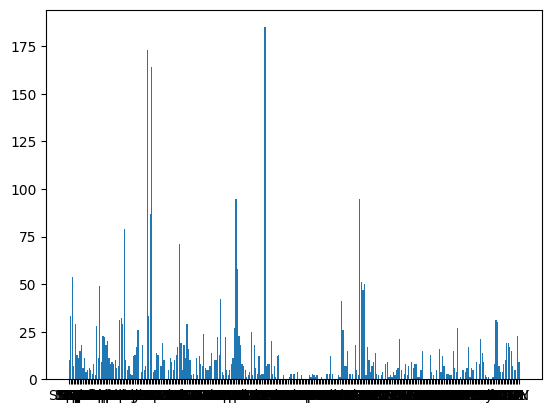

In [62]:
plt.bar(distinct_rois, roi_eid_counts)

In [71]:
sorted_idx = np.argsort(roi_eid_counts)
top20_rois = [distinct_rois[i] for i in sorted_idx[-20:]]

In [70]:
len(eid_dic['MOs'])

185

In [73]:
top20_rois

['RSPagl',
 'RSPd',
 'CA2',
 'MOp',
 'ZI',
 'VPM',
 'PAG',
 'VISp',
 'APN',
 'SCm',
 'MOs',
 'PO',
 'CP',
 'PTLp',
 'CA3',
 'MRN',
 'LP',
 'DG',
 'CA1',
 'CM']

The EID with the most simultaneous recordings is: 2c44a360-5a56-4971-8009-f469fb59de98 with 19
Rois:  ['MOp', 'MOs', 'ACAd', 'ACAv', 'PL', 'ILA', 'TT', 'DP', 'CA3', 'DG', 'ACB', 'OT', 'LSr', 'SI', 'AMd', 'IAD', 'MD', 'PVT', 'CM']


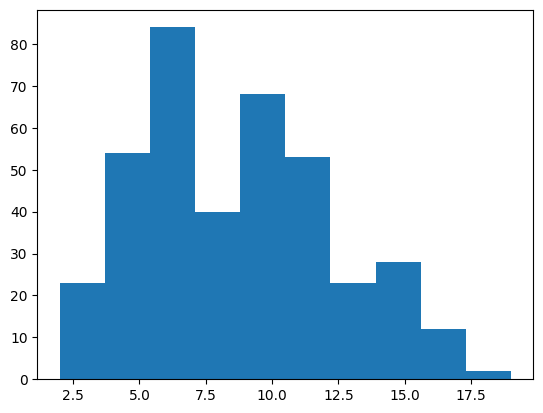

In [41]:
record_lens = [len(record) for record in roi_records]
highscore_ind = np.argmax(record_lens)

plt.hist(record_lens)

# highscore_ind is the index corresponding to an eid
# 
eid_most = all_eids[highscore_ind]
corr_regions = roi_records[highscore_ind]
print('The EID with the most simultaneous recordings is: ' + eid_most + ' with ' + str(len(corr_regions)))
print('Rois: ', corr_regions)

3) Dataset generation below

In [42]:
eid_most = '2c44a360-5a56-4971-8009-f469fb59de98'

#this code is written for an eid with two pids (two probes)

datalist = get_spikedata(eid_most)
trials = one.load_object(eid_most, 'trials')

region_2_relevneur = {}
region_2_data = {}

# def get_matrices(trials, spikes, relev_neur, param = 'choice', param_condition = -1):
count = 0
for region in corr_regions:
    probe = 0
    relev_neur = [i for i, acronym in enumerate(datalist[probe][1]['acronym']) if region in acronym] #datalist[probe][1 = cluster]
    if len(relev_neur) == 0:
        probe = 1
        relev_neur = [i for i, acronym in enumerate(datalist[probe][1]['acronym']) if region in acronym]
    region_2_relevneur[region] = relev_neur
    
    dic = {}
    for condition in [-1,1]:
        mini_dic = {}
        peth, spike_counts, trial_data = get_matrices(trials, datalist[probe][0], relev_neur, param = 'choice', param_condition=condition)
        mini_dic['peth'] = peth
        mini_dic['spike_counts'] = spike_counts
        mini_dic['trial_data'] = trial_data
        dic[condition] = mini_dic
    region_2_data[region] = dic

(['688606f8-9733-46f2-8331-b2dd84c5d385', 'eab03c6e-bf98-48d2-8a0c-1887f34dd554'], ['probe01', 'probe00'])


/home/users/akashc/Downloads/ONE/openalyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-23/001/alf/probe01/pykilosort/spikes.times.npy: 100%|█| 54.0M/54.0M [00:07<00:00, 
/home/users/akashc/Downloads/ONE/openalyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-23/001/alf/probe01/pykilosort/spikes.amps.npy: 100%|█| 54.0M/54.0M [00:05<00:00, 9
/home/users/akashc/Downloads/ONE/openalyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-23/001/alf/probe01/pykilosort/spikes.depths.npy: 100%|█| 54.0M/54.0M [00:06<00:00,
/home/users/akashc/Downloads/ONE/openalyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-23/001/alf/probe01/pykilosort/spikes.clusters.npy: 100%|█| 27.0M/27.0M [00:05<00:0
/home/users/akashc/Downloads/ONE/openalyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-23/001/alf/probe01/pykilosort/clusters.metrics.pqt: 100%|█| 89.3k/89.3k [00:00<00:
/home/users/akashc/Downloads/ONE/openalyx.internationalbrain

348 [52.88476347999532, 71.39076347999328, 85.09276347999177, 93.57476347999084, 97.13776347999045, 100.1837634799901, 107.24476347998933, 112.42576347998876, 117.15476347998825, 120.13176347998791, 124.36776347998745, 127.17476347998713, 132.19176347998658, 135.26776347998623, 139.51076347998577, 148.30476347998479, 156.83176347998386, 166.14176347998284, 170.79676347998233, 178.69876347998144, 186.17576347998062, 195.5507634799796, 203.10876347997876, 207.84676347997825, 211.32276347997785, 215.5117634799774, 222.9517634799766, 228.9937634799759, 235.24676347997521, 240.61476347997464, 248.0527634799738, 258.25976347997266, 266.92876347997174, 273.849763479971, 278.9087634799704, 286.63376347996956, 293.0397634799689, 303.3587634799677, 306.4637634799674, 315.2027634799664, 325.7137634799653, 334.5967634799643, 338.0987634799639, 342.88176347996335, 369.06176347996046, 376.2307634799597, 387.1887634799585, 390.7467634799581, 396.83876347995744, 400.50676347995704, 403.54676347995667,

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (117, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (348, 117, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
9071.596166055895

whole_window is shaped: (348, 117)
This variable is TxN (trials x neurons) and contains summed spike rates per trial
252 [48.762763479995776, 56.367763479994935, 59.566763479994584, 63.566763479994144, 67.82976347999367, 76.13076347999277, 81.96476347999211, 90.76976347999116, 142.40176347998545, 153.6667634799842, 162.15476347998327, 175.6647634799818, 189.43776347998028, 198.96876347997923, 219.8747634799769, 232.09276347997556, 244.84476347997418, 254.84976347997306, 263.78476347997207, 270.63976347997135, 283.10076347996994, 298.62576347996827, 318.771763479966, 322.1847634799656, 331.3327634799646, 348.38076347996275, 351.6557634799624, 358.345

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (38, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (252, 38, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
1952.158036635354

whole_window is shaped: (252, 38)
This variable is TxN (trials x neurons) and contains summed spike rates per trial
348 [52.88476347999532, 71.39076347999328, 85.09276347999177, 93.57476347999084, 97.13776347999045, 100.1837634799901, 107.24476347998933, 112.42576347998876, 117.15476347998825, 120.13176347998791, 124.36776347998745, 127.17476347998713, 132.19176347998658, 135.26776347998623, 139.51076347998577, 148.30476347998479, 156.83176347998386, 166.14176347998284, 170.79676347998233, 178.69876347998144, 186.17576347998062, 195.5507634799796, 203.10876347997876, 207.84676347997825, 211.32276347997785, 215.5117634799774, 222.9517634799766, 228.993

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (33, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (252, 33, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
4704.065688316863

whole_window is shaped: (252, 33)
This variable is TxN (trials x neurons) and contains summed spike rates per trial
348 [52.88476347999532, 71.39076347999328, 85.09276347999177, 93.57476347999084, 97.13776347999045, 100.1837634799901, 107.24476347998933, 112.42576347998876, 117.15476347998825, 120.13176347998791, 124.36776347998745, 127.17476347998713, 132.19176347998658, 135.26776347998623, 139.51076347998577, 148.30476347998479, 156.83176347998386, 166.14176347998284, 170.79676347998233, 178.69876347998144, 186.17576347998062, 195.5507634799796, 203.10876347997876, 207.84676347997825, 211.32276347997785, 215.5117634799774, 222.9517634799766, 228.993

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (39, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (252, 39, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
3020.771259132343

whole_window is shaped: (252, 39)
This variable is TxN (trials x neurons) and contains summed spike rates per trial
348 [52.88476347999532, 71.39076347999328, 85.09276347999177, 93.57476347999084, 97.13776347999045, 100.1837634799901, 107.24476347998933, 112.42576347998876, 117.15476347998825, 120.13176347998791, 124.36776347998745, 127.17476347998713, 132.19176347998658, 135.26776347998623, 139.51076347998577, 148.30476347998479, 156.83176347998386, 166.14176347998284, 170.79676347998233, 178.69876347998144, 186.17576347998062, 195.5507634799796, 203.10876347997876, 207.84676347997825, 211.32276347997785, 215.5117634799774, 222.9517634799766, 228.993

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (212, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (348, 212, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
4832.365880187468

whole_window is shaped: (348, 212)
This variable is TxN (trials x neurons) and contains summed spike rates per trial
252 [48.762763479995776, 56.367763479994935, 59.566763479994584, 63.566763479994144, 67.82976347999367, 76.13076347999277, 81.96476347999211, 90.76976347999116, 142.40176347998545, 153.6667634799842, 162.15476347998327, 175.6647634799818, 189.43776347998028, 198.96876347997923, 219.8747634799769, 232.09276347997556, 244.84476347997418, 254.84976347997306, 263.78476347997207, 270.63976347997135, 283.10076347996994, 298.62576347996827, 318.771763479966, 322.1847634799656, 331.3327634799646, 348.38076347996275, 351.6557634799624, 358.345

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (23, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (348, 23, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
3055.2810018065443

whole_window is shaped: (348, 23)
This variable is TxN (trials x neurons) and contains summed spike rates per trial
252 [48.762763479995776, 56.367763479994935, 59.566763479994584, 63.566763479994144, 67.82976347999367, 76.13076347999277, 81.96476347999211, 90.76976347999116, 142.40176347998545, 153.6667634799842, 162.15476347998327, 175.6647634799818, 189.43776347998028, 198.96876347997923, 219.8747634799769, 232.09276347997556, 244.84476347997418, 254.84976347997306, 263.78476347997207, 270.63976347997135, 283.10076347996994, 298.62576347996827, 318.771763479966, 322.1847634799656, 331.3327634799646, 348.38076347996275, 351.6557634799624, 358.34576

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (27, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (348, 27, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
3364.4445306766465

whole_window is shaped: (348, 27)
This variable is TxN (trials x neurons) and contains summed spike rates per trial
252 [48.762763479995776, 56.367763479994935, 59.566763479994584, 63.566763479994144, 67.82976347999367, 76.13076347999277, 81.96476347999211, 90.76976347999116, 142.40176347998545, 153.6667634799842, 162.15476347998327, 175.6647634799818, 189.43776347998028, 198.96876347997923, 219.8747634799769, 232.09276347997556, 244.84476347997418, 254.84976347997306, 263.78476347997207, 270.63976347997135, 283.10076347996994, 298.62576347996827, 318.771763479966, 322.1847634799656, 331.3327634799646, 348.38076347996275, 351.6557634799624, 358.34576

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (251, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (348, 251, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
8451.292149724799

whole_window is shaped: (348, 251)
This variable is TxN (trials x neurons) and contains summed spike rates per trial
252 [48.762763479995776, 56.367763479994935, 59.566763479994584, 63.566763479994144, 67.82976347999367, 76.13076347999277, 81.96476347999211, 90.76976347999116, 142.40176347998545, 153.6667634799842, 162.15476347998327, 175.6647634799818, 189.43776347998028, 198.96876347997923, 219.8747634799769, 232.09276347997556, 244.84476347997418, 254.84976347997306, 263.78476347997207, 270.63976347997135, 283.10076347996994, 298.62576347996827, 318.771763479966, 322.1847634799656, 331.3327634799646, 348.38076347996275, 351.6557634799624, 358.345

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (98, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (348, 98, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
6630.24788375216

whole_window is shaped: (348, 98)
This variable is TxN (trials x neurons) and contains summed spike rates per trial
252 [48.762763479995776, 56.367763479994935, 59.566763479994584, 63.566763479994144, 67.82976347999367, 76.13076347999277, 81.96476347999211, 90.76976347999116, 142.40176347998545, 153.6667634799842, 162.15476347998327, 175.6647634799818, 189.43776347998028, 198.96876347997923, 219.8747634799769, 232.09276347997556, 244.84476347997418, 254.84976347997306, 263.78476347997207, 270.63976347997135, 283.10076347996994, 298.62576347996827, 318.771763479966, 322.1847634799656, 331.3327634799646, 348.38076347996275, 351.6557634799624, 358.3457634

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (55, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (348, 55, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
3755.669048252255

whole_window is shaped: (348, 55)
This variable is TxN (trials x neurons) and contains summed spike rates per trial
252 [48.762763479995776, 56.367763479994935, 59.566763479994584, 63.566763479994144, 67.82976347999367, 76.13076347999277, 81.96476347999211, 90.76976347999116, 142.40176347998545, 153.6667634799842, 162.15476347998327, 175.6647634799818, 189.43776347998028, 198.96876347997923, 219.8747634799769, 232.09276347997556, 244.84476347997418, 254.84976347997306, 263.78476347997207, 270.63976347997135, 283.10076347996994, 298.62576347996827, 318.771763479966, 322.1847634799656, 331.3327634799646, 348.38076347996275, 351.6557634799624, 358.345763

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (13, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (348, 13, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
1826.8259358789496

whole_window is shaped: (348, 13)
This variable is TxN (trials x neurons) and contains summed spike rates per trial
252 [48.762763479995776, 56.367763479994935, 59.566763479994584, 63.566763479994144, 67.82976347999367, 76.13076347999277, 81.96476347999211, 90.76976347999116, 142.40176347998545, 153.6667634799842, 162.15476347998327, 175.6647634799818, 189.43776347998028, 198.96876347997923, 219.8747634799769, 232.09276347997556, 244.84476347997418, 254.84976347997306, 263.78476347997207, 270.63976347997135, 283.10076347996994, 298.62576347996827, 318.771763479966, 322.1847634799656, 331.3327634799646, 348.38076347996275, 351.6557634799624, 358.34576

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (27, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (348, 27, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
3033.4386428606067

whole_window is shaped: (348, 27)
This variable is TxN (trials x neurons) and contains summed spike rates per trial
252 [48.762763479995776, 56.367763479994935, 59.566763479994584, 63.566763479994144, 67.82976347999367, 76.13076347999277, 81.96476347999211, 90.76976347999116, 142.40176347998545, 153.6667634799842, 162.15476347998327, 175.6647634799818, 189.43776347998028, 198.96876347997923, 219.8747634799769, 232.09276347997556, 244.84476347997418, 254.84976347997306, 263.78476347997207, 270.63976347997135, 283.10076347996994, 298.62576347996827, 318.771763479966, 322.1847634799656, 331.3327634799646, 348.38076347996275, 351.6557634799624, 358.34576

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (46, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (348, 46, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
4919.347517710047

whole_window is shaped: (348, 46)
This variable is TxN (trials x neurons) and contains summed spike rates per trial
252 [48.762763479995776, 56.367763479994935, 59.566763479994584, 63.566763479994144, 67.82976347999367, 76.13076347999277, 81.96476347999211, 90.76976347999116, 142.40176347998545, 153.6667634799842, 162.15476347998327, 175.6647634799818, 189.43776347998028, 198.96876347997923, 219.8747634799769, 232.09276347997556, 244.84476347997418, 254.84976347997306, 263.78476347997207, 270.63976347997135, 283.10076347996994, 298.62576347996827, 318.771763479966, 322.1847634799656, 331.3327634799646, 348.38076347996275, 351.6557634799624, 358.345763

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (84, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (348, 84, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
3109.7115621870785

whole_window is shaped: (348, 84)
This variable is TxN (trials x neurons) and contains summed spike rates per trial
252 [48.762763479995776, 56.367763479994935, 59.566763479994584, 63.566763479994144, 67.82976347999367, 76.13076347999277, 81.96476347999211, 90.76976347999116, 142.40176347998545, 153.6667634799842, 162.15476347998327, 175.6647634799818, 189.43776347998028, 198.96876347997923, 219.8747634799769, 232.09276347997556, 244.84476347997418, 254.84976347997306, 263.78476347997207, 270.63976347997135, 283.10076347996994, 298.62576347996827, 318.771763479966, 322.1847634799656, 331.3327634799646, 348.38076347996275, 351.6557634799624, 358.34576

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (16, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (252, 16, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
2367.4475706971843

whole_window is shaped: (252, 16)
This variable is TxN (trials x neurons) and contains summed spike rates per trial


In [43]:
#summarize dimensions
#peth means is neurons by time (averaged over trials)
#spike_counts is trials by neurons by time
#trial_data contains behavioral parameters (choice, feedback, movement_initiation_time, etc)

for roi in region_2_data:
    print('ROI: ', roi)
    for condition in [-1,1]:
        print('Choice: ', condition)
        print(region_2_data[roi][condition]['peth']['means'].shape)
        print(region_2_data[roi][condition]['spike_counts'].shape)
        print(region_2_data[roi][condition]['trial_data']['choices'].shape)

ROI:  MOp
Choice:  -1
(15, 120)
(348, 15, 120)
(348,)
Choice:  1
(15, 120)
(252, 15, 120)
(252,)
ROI:  MOs
Choice:  -1
(117, 120)
(348, 117, 120)
(348,)
Choice:  1
(117, 120)
(252, 117, 120)
(252,)
ROI:  ACAd
Choice:  -1
(38, 120)
(348, 38, 120)
(348,)
Choice:  1
(38, 120)
(252, 38, 120)
(252,)
ROI:  ACAv
Choice:  -1
(33, 120)
(348, 33, 120)
(348,)
Choice:  1
(33, 120)
(252, 33, 120)
(252,)
ROI:  PL
Choice:  -1
(39, 120)
(348, 39, 120)
(348,)
Choice:  1
(39, 120)
(252, 39, 120)
(252,)
ROI:  ILA
Choice:  -1
(212, 120)
(348, 212, 120)
(348,)
Choice:  1
(212, 120)
(252, 212, 120)
(252,)
ROI:  TT
Choice:  -1
(9, 120)
(348, 9, 120)
(348,)
Choice:  1
(9, 120)
(252, 9, 120)
(252,)
ROI:  DP
Choice:  -1
(3, 120)
(348, 3, 120)
(348,)
Choice:  1
(3, 120)
(252, 3, 120)
(252,)
ROI:  CA3
Choice:  -1
(23, 120)
(348, 23, 120)
(348,)
Choice:  1
(23, 120)
(252, 23, 120)
(252,)
ROI:  DG
Choice:  -1
(27, 120)
(348, 27, 120)
(348,)
Choice:  1
(27, 120)
(252, 27, 120)
(252,)
ROI:  ACB
Choice:  -1
(251, 120)

In [44]:
#first pass classification task
from sklearn.model_selection import train_test_split
from sklearn import metrics
def check_accuracy_peregion(model, squash = 'mean'):

    rois = region_2_data.keys()

    for ex_roi in rois:
        num_trials = region_2_data[ex_roi][-1]['trial_data']['choices'].shape[0] + region_2_data[ex_roi][1]['trial_data']['choices'].shape[0]
        training_size = 480
        T = region_2_data[ex_roi][1]['spike_counts'].shape[-1]
        whole_data = []
        whole_outputs = []

        for condition in [-1,1]:
            spike_counts = region_2_data[ex_roi][condition]['spike_counts']
            if squash == 'mean':
                # print(spike_counts.shape)
                dat = np.mean(spike_counts, axis=1) #averaging over neurons
                # print(dat.shape)
            elif squash == 'vec':
                dat = spike_counts.reshape(spike_counts.shape[0],-1)

            whole_data.append(dat)
            whole_outputs.append(region_2_data[ex_roi][condition]['trial_data']['choices'])
        whole_data = np.vstack(whole_data)
        whole_outputs = np.hstack(whole_outputs)
        print(whole_data.shape, whole_outputs.shape)

        X_train, X_test, y_train, y_test = train_test_split(whole_data, whole_outputs, test_size=0.2)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Model Accuracy: how often is the classifier correct?
        print(ex_roi + " accuracy:",metrics.accuracy_score(y_test, y_pred))

In [45]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
check_accuracy_peregion(clf, squash = 'mean')
print('\nWith vectorize')
check_accuracy_peregion(clf, squash = 'vec')

(600, 120) (600,)
MOp accuracy: 0.625
(600, 120) (600,)
MOs accuracy: 0.6333333333333333
(600, 120) (600,)
ACAd accuracy: 0.6
(600, 120) (600,)
ACAv accuracy: 0.6416666666666667
(600, 120) (600,)
PL accuracy: 0.5833333333333334
(600, 120) (600,)
ILA accuracy: 0.6333333333333333
(600, 120) (600,)
TT accuracy: 0.5583333333333333
(600, 120) (600,)
DP accuracy: 0.6166666666666667
(600, 120) (600,)
CA3 accuracy: 0.6
(600, 120) (600,)
DG accuracy: 0.575
(600, 120) (600,)
ACB accuracy: 0.5583333333333333
(600, 120) (600,)
OT accuracy: 0.5833333333333334
(600, 120) (600,)
LSr accuracy: 0.5416666666666666
(600, 120) (600,)
SI accuracy: 0.5583333333333333
(600, 120) (600,)
AMd accuracy: 0.6
(600, 120) (600,)
IAD accuracy: 0.6666666666666666
(600, 120) (600,)
MD accuracy: 0.5666666666666667
(600, 120) (600,)
PVT accuracy: 0.5583333333333333
(600, 120) (600,)
CM accuracy: 0.625

With vectorize
(600, 1800) (600,)
MOp accuracy: 0.6583333333333333
(600, 14040) (600,)
MOs accuracy: 0.7916666666666666


In [46]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
check_accuracy_peregion(clf, squash = 'mean')
print('\nWith vectorize')
check_accuracy_peregion(clf, squash = 'vec')

(600, 120) (600,)
MOp accuracy: 0.6333333333333333
(600, 120) (600,)
MOs accuracy: 0.6083333333333333
(600, 120) (600,)
ACAd accuracy: 0.6083333333333333
(600, 120) (600,)
ACAv accuracy: 0.5666666666666667
(600, 120) (600,)
PL accuracy: 0.6
(600, 120) (600,)
ILA accuracy: 0.48333333333333334
(600, 120) (600,)
TT accuracy: 0.525
(600, 120) (600,)
DP accuracy: 0.6083333333333333
(600, 120) (600,)
CA3 accuracy: 0.6333333333333333
(600, 120) (600,)
DG accuracy: 0.5166666666666667
(600, 120) (600,)
ACB accuracy: 0.5416666666666666
(600, 120) (600,)
OT accuracy: 0.5666666666666667
(600, 120) (600,)
LSr accuracy: 0.55
(600, 120) (600,)
SI accuracy: 0.5583333333333333
(600, 120) (600,)
AMd accuracy: 0.6
(600, 120) (600,)
IAD accuracy: 0.6583333333333333
(600, 120) (600,)
MD accuracy: 0.6416666666666667
(600, 120) (600,)
PVT accuracy: 0.6
(600, 120) (600,)
CM accuracy: 0.6583333333333333

With vectorize
(600, 1800) (600,)
MOp accuracy: 0.65
(600, 14040) (600,)
MOs accuracy: 0.775
(600, 4560) (6

In [49]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
check_accuracy_peregion(gnb)

(600, 120) (600,)
MOp accuracy: 0.5416666666666666
(600, 120) (600,)
MOs accuracy: 0.6083333333333333
(600, 120) (600,)
ACAd accuracy: 0.7
(600, 120) (600,)
ACAv accuracy: 0.65
(600, 120) (600,)
PL accuracy: 0.5833333333333334
(600, 120) (600,)
ILA accuracy: 0.5
(600, 120) (600,)
TT accuracy: 0.5583333333333333
(600, 120) (600,)
DP accuracy: 0.575
(600, 120) (600,)
CA3 accuracy: 0.6083333333333333
(600, 120) (600,)
DG accuracy: 0.5916666666666667
(600, 120) (600,)
ACB accuracy: 0.5916666666666667
(600, 120) (600,)
OT accuracy: 0.55
(600, 120) (600,)
LSr accuracy: 0.6416666666666667
(600, 120) (600,)
SI accuracy: 0.5416666666666666
(600, 120) (600,)
AMd accuracy: 0.5833333333333334
(600, 120) (600,)
IAD accuracy: 0.575
(600, 120) (600,)
MD accuracy: 0.5416666666666666
(600, 120) (600,)
PVT accuracy: 0.6416666666666667
(600, 120) (600,)
CM accuracy: 0.5916666666666667


In [48]:
from sklearn.linear_model import LogisticRegression
clf_logr = LogisticRegression(random_state=0)
check_accuracy_peregion(clf_logr)

(600, 120) (600,)
MOp accuracy: 0.6666666666666666
(600, 120) (600,)
MOs accuracy: 0.6333333333333333
(600, 120) (600,)
ACAd accuracy: 0.6
(600, 120) (600,)
ACAv accuracy: 0.5833333333333334
(600, 120) (600,)
PL accuracy: 0.5666666666666667
(600, 120) (600,)
ILA accuracy: 0.55
(600, 120) (600,)
TT accuracy: 0.575
(600, 120) (600,)
DP accuracy: 0.5416666666666666
(600, 120) (600,)
CA3 accuracy: 0.6833333333333333
(600, 120) (600,)
DG accuracy: 0.5916666666666667
(600, 120) (600,)
ACB accuracy: 0.675
(600, 120) (600,)
OT accuracy: 0.575
(600, 120) (600,)
LSr accuracy: 0.5083333333333333
(600, 120) (600,)
SI accuracy: 0.5083333333333333
(600, 120) (600,)
AMd accuracy: 0.575
(600, 120) (600,)
IAD accuracy: 0.5666666666666667
(600, 120) (600,)
MD accuracy: 0.5666666666666667
(600, 120) (600,)
PVT accuracy: 0.6833333333333333
(600, 120) (600,)
CM accuracy: 0.6333333333333333


In [51]:
#first pass classification task

rois = region_2_data.keys()
X_trains = None
X_tests = None

for ex_roi in rois:
    num_trials = region_2_data[ex_roi][-1]['trial_data']['choices'].shape[0] + region_2_data[ex_roi][1]['trial_data']['choices'].shape[0]
    training_size = 480

    T = region_2_data[ex_roi][1]['spike_counts'].shape[-1]
    whole_data = []
    whole_outputs = []

    for condition in [-1,1]:
        spike_counts = region_2_data[ex_roi][condition]['spike_counts']

        whole_data.append(spike_counts)
        whole_outputs.append(region_2_data[ex_roi][condition]['trial_data']['choices'])
    whole_data = np.vstack(whole_data)
    whole_outputs = np.hstack(whole_outputs)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(whole_data, whole_outputs, test_size=0.2)
    if X_trains is None:
        X_trains = X_train
        X_tests = X_test
    else:
        print(X_trains.shape, X_train.shape)
        X_trains = np.hstack([X_trains, X_train])
        X_tests = np.hstack([X_tests, X_test])
    

print(X_trains.shape)
print(X_tests.shape)



(480, 15, 120) (480, 117, 120)
(480, 132, 120) (480, 38, 120)
(480, 170, 120) (480, 33, 120)
(480, 203, 120) (480, 39, 120)
(480, 242, 120) (480, 212, 120)
(480, 454, 120) (480, 9, 120)
(480, 463, 120) (480, 3, 120)
(480, 466, 120) (480, 23, 120)
(480, 489, 120) (480, 27, 120)
(480, 516, 120) (480, 251, 120)
(480, 767, 120) (480, 4, 120)
(480, 771, 120) (480, 98, 120)
(480, 869, 120) (480, 55, 120)
(480, 924, 120) (480, 13, 120)
(480, 937, 120) (480, 27, 120)
(480, 964, 120) (480, 46, 120)
(480, 1010, 120) (480, 84, 120)
(480, 1094, 120) (480, 16, 120)
(480, 1110, 120)
(120, 1110, 120)


In [52]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_trains, y_train)
y_pred = clf.predict(X_tests)
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print(ex_roi + " accuracy:",metrics.accuracy_score(y_test, y_pred))

ValueError: Found array with dim 3. SVC expected <= 2.